Temp   -6.3
dtype: float64 Temp    39.2
dtype: float64


,Temp
0,8.4
1,8.8
2,9.2
3,9.3
4,9.4
...,...
52412,-1.0
52413,-1.1
52414,-1.1
52415,-1.1


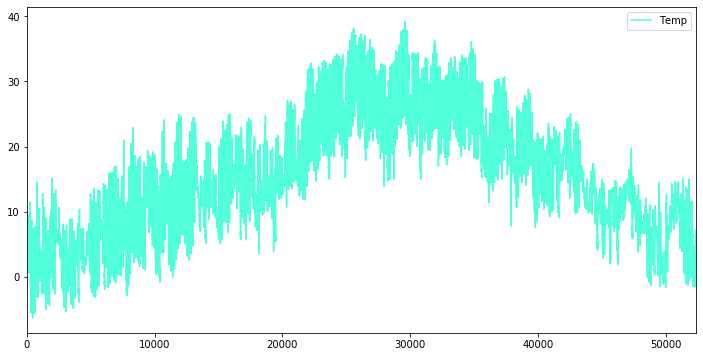

In [10]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np

temp=pd.read_csv("hourlydataOspitaletto.csv",usecols=["Temp"] ,squeeze=True)
df=DataFrame(temp,columns=["Temp"])
mypalette = sns.color_palette(['#51ffda']) # https://www.hsluv.org/
sns.set_palette(mypalette)

df.loc[df['Temp'] == -999, 'Temp'] = 15

df.plot(figsize=(12,6))

print(df.min(),df.max())
df

In [12]:
import seaborn as sns

df=pd.read_csv("hourlydataOspitaletto.csv",index_col=0, parse_dates=True)

df['Data-Ora'] =pd.to_datetime(df['Data-Ora'], infer_datetime_format=True) #Estoy asociando el index de tiempo a la columna Data-Ora

df=df.set_index('Data-Ora')

df.loc[df['Temp'] == -999, 'Temp'] = df['Temp'].mean()


# Definition of the tentative values of Tamb_avg, DT_year, d_shift_min and d_shift_max

In [17]:
#Este codigo debe ejecutarse después de definir df con un index de tiempo a través de .to_datetime

from math import cos, sin, exp, sqrt
import numpy as np

hourly_df=df['Temp'].resample('H').mean() #Grafico resolución horaria
T_daily_avg=df["Temp"].resample('D').mean() #columna de valores promedios en escala de tiempo diaria
T_monthly_avg=df["Temp"].resample('M').mean()


T_monthly_avg=T_monthly_avg.reset_index() #Reseteo el index de fecha por uno por defecto
T_monthly_avg["Data-Ora"]= T_monthly_avg.index+1


T_daily_avg=T_daily_avg.reset_index() #Reseteo el index de fecha por uno por defecto
T_daily_avg["Data-Ora"]= T_daily_avg.index+1


T_ave_h=T_daily_avg['Temp'].mean() #Average dataset temperature
T_max=T_daily_avg['Temp'].max() #Max dataset temperature
DT_y = T_max-T_ave_h #Temperature swing Tmax-Tmean

d_shift_min=T_daily_avg['Temp'].idxmin(axis=0)+1 #Day of the min T
d_shift_max=T_daily_avg['Temp'].idxmax(axis=0)+1 #Day of the max T
print('T_ave_h' ,T_ave_h,'DT_y',DT_y, 'd_shift_min',d_shift_min,T_daily_avg['Temp'].min(),'d_shift_max', d_shift_max, T_daily_avg['Temp'].max())

t=T_daily_avg['Data-Ora']

t_0=T_daily_avg['Temp'].count() #Number of days in a year =365 days
hours=hourly_df.count() #Number of hours in a year =8737 hrs

h=pd.Series(range(1, 8761)) #A range equivalent to the hours of the year from 1 to 8761

hourly_df

T_ave_h 15.319880946122295 DT_y 16.85789683165548 d_shift_min 4 -0.9270833333333321 d_shift_max 206 32.17777777777778


Data-Ora
2019-01-01 00:00:00    9.100000
2019-01-01 01:00:00    9.200000
2019-01-01 02:00:00    9.166667
2019-01-01 03:00:00    9.183333
2019-01-01 04:00:00    8.916667
                         ...   
2019-12-30 20:00:00    0.733333
2019-12-30 21:00:00   -0.100000
2019-12-30 22:00:00   -0.250000
2019-12-30 23:00:00   -0.983333
2019-12-31 00:00:00   -0.800000
Freq: H, Name: Temp, Length: 8737, dtype: float64

In [5]:
hourly_df.to_excel(r'/Users/selvacalixto/Desktop/Jupyter/original/Tamb_hourly.xls',index=False)

# This code finds the optimal curve that better fits the raw data through the minimum square method 

In [18]:
import matplotlib.pyplot as plt
from scipy import optimize
from math import exp, cos, sqrt, pi
from IPython.display import display, Math
from scipy.optimize import curve_fit
import numpy as np

def func(x, disp, amp, phi):
    t0= len(h) #hourly resolution if x is in hours
    omega= 2*pi/t0
    return disp + amp * np.cos(x* omega - phi) 

x_data = pd.Series(range(0,len(hourly_df)))
y_data = hourly_df
params, params_covariance = optimize.curve_fit(func, x_data, y_data, p0=[T_ave_h, DT_y, d_shift_max*24])



#For mor info: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit

In [29]:
print('Fitted parameters:')
display(Math('dist={:.2f}, amp={:.2f}, \\phi={:.2f}'.format(*params)))
print('Original parameters:')
display(Math('dist={:.2f}, amp={:.2f}, \\phi={:.2f}'.format(*[T_ave_h, DT_y, d_shift_max*24])))
#'displacement, amplitude, and phase of the signal

parameters=pd.Series(params)
T_ave_fit = parameters[0]
DT_y_fit = parameters[1]
phi= parameters[2] #Corresponds to day 202
parameters[0]
parameters[1]


Fitted parameters:


<IPython.core.display.Math object>

Original parameters:


<IPython.core.display.Math object>

-11.231470623985066

# The new ambient temperature curve uses the fitted parameters as input

In [23]:
def fitting_curve(x):
    T_ave_fit
    DT_y_fit
    T=len(h)
    omega = 2*pi/T
    phi
    return  T_ave_fit + DT_y_fit * np.cos(x* omega - phi) 

d_min (h): 476 day_number 19.833333333333332 d_max (h): 4856 day_number 202.33333333333334


RangeIndex(start=0, stop=8760, step=1)

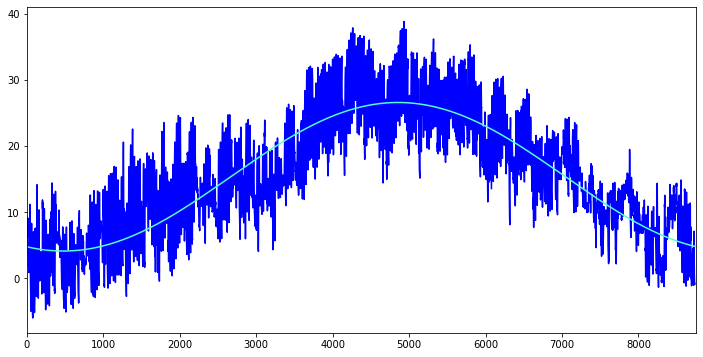

In [32]:
new_curve=h.apply(lambda x: fitting_curve(x))
plt.plot(x_data, y_data, color= "blue")
new_curve.plot(figsize = (12,6))
new_curve.min()
d_shift_min = new_curve.idxmin(axis=0)
d_shift_max = new_curve.idxmax(axis=0)
dd_min = d_shift_min/24
dd_max = d_shift_max/24

print('d_min (h):',d_shift_min, 'day_number', dd_min,'d_max (h):',d_shift_max, 'day_number', dd_max)


In [16]:
new_curve.to_excel(r'/Users/selvacalixto/Desktop/Jupyter/original/Tamb_input.xls',index=False)

# Ground temperature as a function of the ambient temperature fitting curve

In [46]:
# The purpose of having two equations is to show that they both work using the same input data
zz=1               #Depth [m]
alpha=0.06048      #Ground thermal diffusivity, Banks [m^2/day]
alpha_sec=7e-7 #Ground thermal diffusivity, Banks [m^2/s]
t_sec=365*24*3600

Tg_und = T_ave_fit #Undisturbed ground temperature
DT_y=abs(DT_y_fit)


def ground_temperature_day(t):
    #t corresponds to the number of day from 1 to 365
    T_banks= Tg_und+DT_y*exp(-zz*sqrt(pi/(alpha*t_0)))*cos(2*pi/t_0*(t-dd_max)-zz*sqrt(pi/(alpha*t_0))) #Banks + t_shift 

    T_kusuda = Tg_und-DT_y*exp(-zz*sqrt(pi/(alpha*t_0)))*cos(2*pi/t_0*(t-dd_min-zz/2*sqrt(t_0/(pi*alpha)))) #Kusuda
    
    #return  (pd.Series({'T_banks': T_banks,'T_kusuda': T_kusuda,'T_banks_noshift:': T_banks_noshift}))
    return  (pd.Series({'T_banks': T_banks,'T_kusuda': T_kusuda}))

def ground_temperature_month(month):
    #t corresponds to the number of month from 1 to 12
    T_banks= Tg_und+DT_y*exp(-zz*sqrt(pi/(alpha*t_0)))*cos(2*pi/t_0*(15+(month-1)*30-dd_max)-zz*sqrt(pi/(alpha*t_0))) #Banks + t_shift 
    
    T_kusuda = Tg_und-DT_y*exp(-zz*sqrt(pi/(alpha*t_0)))*cos(2*pi/t_0*(15+(month-1)*30-dd_min-zz/2*sqrt(t_0/(pi*alpha)))) #Kusuda ->Selva's
    return  (pd.Series({'T_banks': T_banks,'T_kusuda': T_kusuda}))

def ground_temperature_hour(t):
    #t is time in hours, but the calculation is done is seconds
    T_banks= Tg_und+DT_y*exp(-zz*sqrt(pi/(alpha_sec*t_sec)))*cos(2*pi/t_sec*(t-dd_max*24)*3600-zz*sqrt(pi/(alpha_sec*t_sec))) #Banks + t_shift ->Marco's
    
    T_kusuda = Tg_und-DT_y*exp(-zz*sqrt(pi/(alpha_sec*t_sec)))*cos(2*pi/t_sec*((t-dd_min*24)*3600-zz/2*sqrt(t_sec/(pi*alpha_sec)))) #Kusuda
    return  (pd.Series({'T_banks': T_banks,'T_kusuda': T_kusuda}))


In [45]:
type(T_daily_avg['Data-Ora'])

pandas.core.series.Series

# Output of Banks and Kusuda equations on a daily basis

T_Banks min 15.334414171033245 T_Kusuda min 15.334414171033245


365

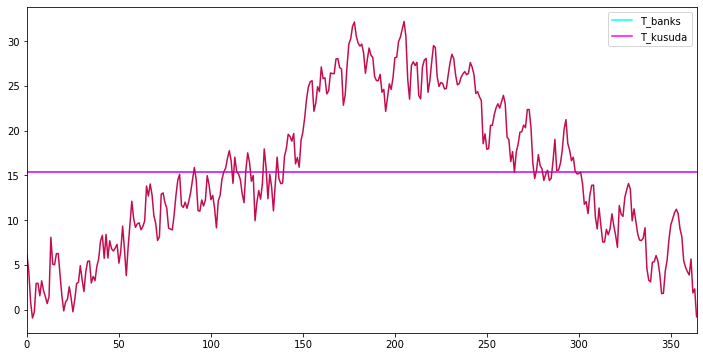

In [42]:
T_ground=T_daily_avg['Data-Ora'].apply(lambda x: ground_temperature_day(x))
T_ground.plot(colormap='cool', figsize=(12,6))
T_daily_avg['Temp'].plot(color='#c40d50', figsize=(12,6),label='Temp')
T_daily_avg['Data-Ora']
print('T_Banks min', T_ground['T_banks'].min(), 'T_Kusuda min', T_ground['T_kusuda'].min())
len(T_ground)

# Output of Banks and Kusuda equations on a monthly basis

T_Banks min 7.644650727551737 T_Kusuda min 7.644650727551737


,T_banks,T_kusuda
0,8.434712,8.434712
1,7.644651,7.644651
2,8.860278,8.860278
3,11.764533,11.764533
4,15.599925,15.599925
5,19.366101,19.366101
6,22.080763,22.080763
7,23.035870,23.035870
8,21.982310,21.982310
9,19.194872,19.194872


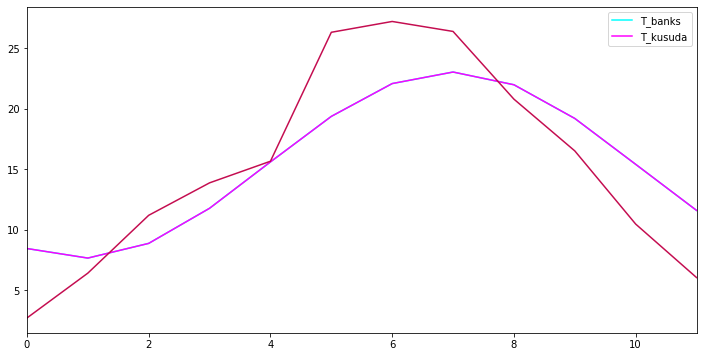

In [32]:
T_ground_m=T_monthly_avg["Data-Ora"].apply(lambda x: ground_temperature_month(x))
T_ground_m.plot(colormap='cool', figsize=(12,6))
T_monthly_avg['Temp'].plot(color='#c40d50', figsize=(12,6),label='Temp')
print('T_Banks min', T_ground_m['T_banks'].min(), 'T_Kusuda min', T_ground_m['T_kusuda'].min())
type(T_monthly_avg["Data-Ora"])
T_ground_m

In [542]:
T_ground_m.to_excel(r'/Users/selvacalixto/Desktop/Jupyter/original/ground_temperature_monthly.xls')

# Output of Banks and Kusuda equations on an hourly basis

In [36]:
hourly_df=hourly_df.reset_index()

T_Banks min 7.632585845641759 T_Kusuda min 7.632585845641759


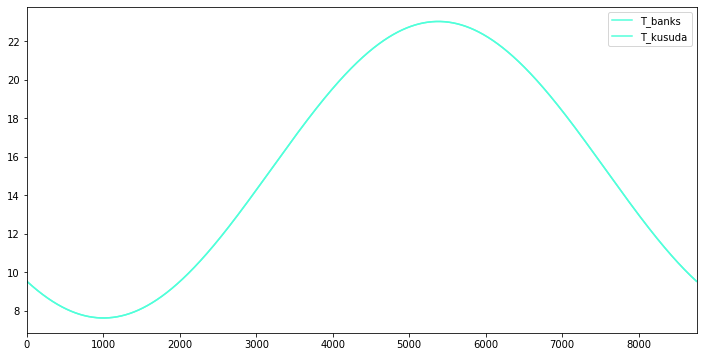

In [40]:
T_ground_sec=h.apply(lambda x: ground_temperature_hour(x))

T_ground_sec.plot(figsize=(12,6))


print('T_Banks min', T_ground_sec['T_banks'].min(), 'T_Kusuda min', T_ground_sec['T_kusuda'].min())